# オプション戦略

In [1]:
import pandas as pd
import ivolat3
from payoff import plot_payoff

pd.options.display.max_rows = 999

s_df = pd.read_pickle('data/s.pickle')
op1_df = pd.read_pickle('data/op1.pickle')
op2_df = pd.read_pickle('data/op1.pickle')

### 2018年2月26日のデータ

In [2]:
t0 = pd.to_datetime('2018-02-26 15:15')
t1 = pd.to_datetime('2018-03-09 09:00')
s0 = s_df.loc[t0, '1803']
r = 0.001
delta_t = t1 - t0
t = (delta_t.days / 365) + (delta_t.seconds / 31536000)
op_df = op1_df.loc['2018-02-26 15:15'].dropna().copy()

In [3]:
'先物価格:{}, 満期までの期間:{}'.format(s0, t)

'先物価格:22214.1, 満期までの期間:0.02942351598173516'

In [4]:
op_df.head()

,price,iv,Call/Put
k,,,
15750.0,1.83762,0.719635,P
16000.0,1.91618,0.692107,P
16250.0,1.98373,0.664316,P
16500.0,2.73333,0.655723,P
16750.0,2.855,0.628376,P


In [5]:
def _get_greeks(fop):
    right, qty_price = fop.split('x')
    qty = float(qty_price.split('@')[0])
    if right == 's':
        return 'f', qty, 0, 0, 0
    
    k = float(right[:-1])
    pc = right[-1]
    sigma = op_df.loc[k, 'iv']
    delta = qty * ivolat3.delta(s0, k, r, 0, t, sigma, pc)
    gamma = qty * ivolat3.gamma(s0, k, r, 0, t, sigma)
    vega = qty * ivolat3.vega(s0, k, r, 0, t, sigma) * 0.01
    theta = qty * ivolat3.theta(s0, k, r, 0, t, sigma, pc) / 365
    return right, delta, gamma, vega, theta

In [6]:
def get_greeks(portfolio):
    df = pd.DataFrame([_get_greeks(p) for p in portfolio],
                     columns=['right', 'delta', 'gamma', 'vega', 'theta'])
    df.set_index('right', inplace=True)
    df.loc['sum'] = df.sum()
    return df

### 2018年3月限のオプションの価格

k: 権利行使価格  
price: 仲値  
iv: ボラティリティ  
Call/Put: コールまたはプット

In [7]:
op1_df.loc['2018-02-26 15:15'].dropna()

,price,iv,Call/Put
k,,,
15750.0,1.83762,0.719635,P
16000.0,1.91618,0.692107,P
16250.0,1.98373,0.664316,P
16500.0,2.73333,0.655723,P
16750.0,2.855,0.628376,P
17000.0,3.52886,0.61238,P
17250.0,3.90949,0.588903,P
17500.0,4.63427,0.569882,P
17750.0,5.09237,0.545632,P


### 先物ロング/ショート

* 相場の上下を予測
* デルタだけをとりにいく戦略

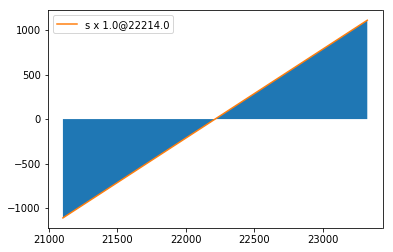

In [8]:
plot_payoff(['sx1@22214'])

In [9]:
get_greeks(['sx1@22214'])

,delta,gamma,vega,theta
right,,,,
f,1.0,0.0,0.0,0.0
sum,1.0,0.0,0.0,0.0


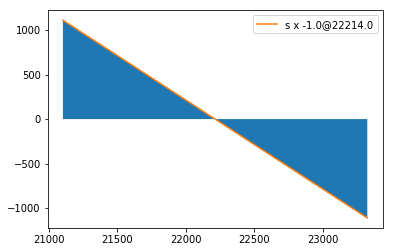

In [10]:
plot_payoff(['sx-1@22214'])

In [11]:
get_greeks(['sx-1@22214'])

,delta,gamma,vega,theta
right,,,,
f,-1.0,0.0,0.0,0.0
sum,-1.0,0.0,0.0,0.0


### ネイキッドロング

* 単純にオプションを買う
* 相場の方向性とボラティリティ上昇の両方を当てにいく
* 損失限定でリスクは比較的小さいがコストはやや高い
* 非常に難しい

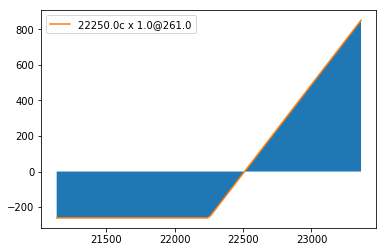

In [12]:
plot_payoff(['22250cx1@261'])

In [13]:
get_greeks(['22250cx1@261'])

,delta,gamma,vega,theta
right,,,,
22250c,0.486102,0.000572,15.192281,-12.972841
sum,0.486102,0.000572,15.192281,-12.972841


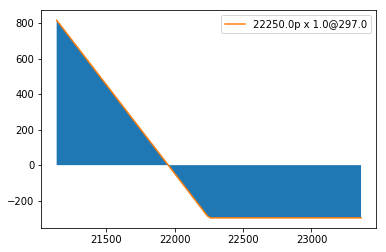

In [14]:
plot_payoff(['22250px1@297'])

In [15]:
get_greeks(['22250px1@297'])

,delta,gamma,vega,theta
right,,,,
22250p,-0.513868,0.000572,15.192281,-12.911884
sum,-0.513868,0.000572,15.192281,-12.911884


### ネイキッドショート

* 単純にオプションを売る
* 相場の方向性とボラティリティ下落の両方を当てにいく
* 損失無限大
* 勝率が高いがリスクが高い

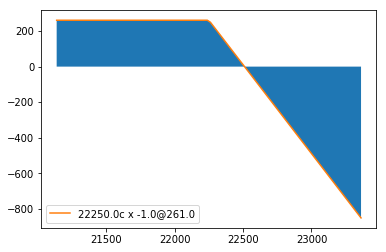

In [16]:
plot_payoff(['22250cx-1@261'])

In [17]:
get_greeks(['22250cx-1@261'])

,delta,gamma,vega,theta
right,,,,
22250c,-0.486102,-0.000572,-15.192281,12.972841
sum,-0.486102,-0.000572,-15.192281,12.972841


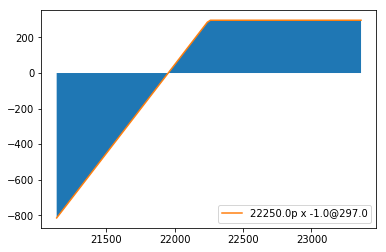

In [18]:
plot_payoff(['22250px-1@297'])

In [19]:
get_greeks(['22250px-1@297'])

,delta,gamma,vega,theta
right,,,,
22250p,0.513868,-0.000572,-15.192281,12.911884
sum,0.513868,-0.000572,-15.192281,12.911884


### プロティクティブコール

* 先物ショートとコール買いを組み合わせた戦略
* コール買いの保険がついた先物売り
* プット買いに似ているが、下落スピードはあまり考慮しなくてよい

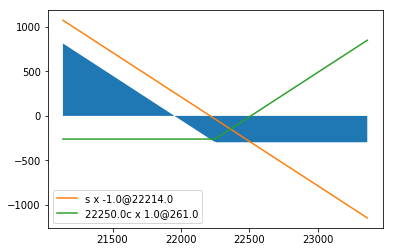

In [20]:
plot_payoff(['sx-1@22214', '22250cx1@261'])

In [21]:
get_greeks(['sx-1@22214', '22250cx1@261'])

,delta,gamma,vega,theta
right,,,,
f,-1.000000,0.000000,0.000000,0.000000
22250c,0.486102,0.000572,15.192281,-12.972841
sum,-0.513898,0.000572,15.192281,-12.972841


### プロティクティブプット

* 先物ロングとプット買いを組み合わせた戦略
* プット買いの保険がついた先物売り
* コール買いに似ているが、上昇スピードはあまり考慮しなくてよい

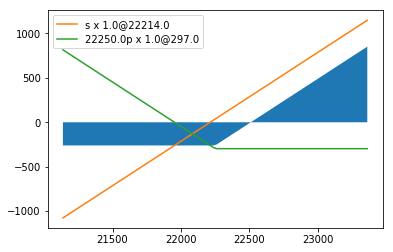

In [22]:
plot_payoff(['sx1@22214', '22250px1@297'])

In [23]:
get_greeks(['sx1@22214', '22250px1@297'])

,delta,gamma,vega,theta
right,,,,
f,1.000000,0.000000,0.000000,0.000000
22250p,-0.513868,0.000572,15.192281,-12.911884
sum,0.486132,0.000572,15.192281,-12.911884


### カバードコール(1:1)

* 先物買いとコール売りを組み合わせた戦略
* 先物買いの利益に上限を設ける代わりにオプションのプレミアムを受け取る
* 先物買いの利益確定の手段として使われることもある

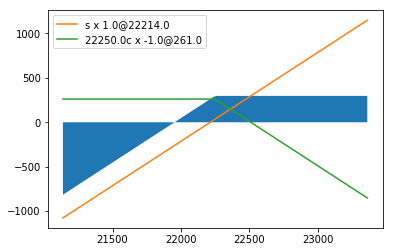

In [24]:
plot_payoff(['sx1@22214', '22250cx-1@261'])

In [25]:
get_greeks(['sx1@22214', '22250cx-1@261'])

,delta,gamma,vega,theta
right,,,,
f,1.000000,0.000000,0.000000,0.000000
22250c,-0.486102,-0.000572,-15.192281,12.972841
sum,0.513898,-0.000572,-15.192281,12.972841


### カバードプット(1:1)

* 先物売りとプット売りを組み合わせた戦略
* 先物売りの利益に上限を設ける代わりにオプションのプレミアムを受け取る
* 先物売りの利益確定の手段として使われることもある

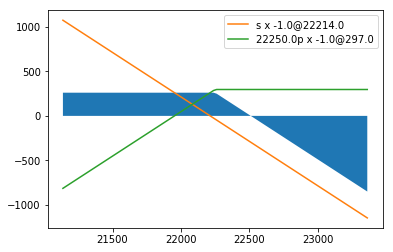

In [26]:
plot_payoff(['sx-1@22214', '22250px-1@297'])

In [27]:
get_greeks(['sx-1@22214', '22250px-1@297'])

,delta,gamma,vega,theta
right,,,,
f,-1.000000,0.000000,0.000000,0.000000
22250p,0.513868,-0.000572,-15.192281,12.911884
sum,-0.486132,-0.000572,-15.192281,12.911884


### カバードコール(ショートストラドル)

* 先物買いとコール売りを複数組み合わせた戦略
* 通常はデルタをニュートラルにする
* 相場が動かないまたはボラティリティが低下することを狙った戦略
* オプションのみで組成したショートストラドルよりはリスクが少ない

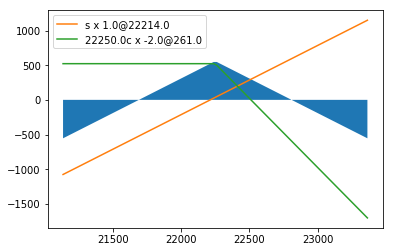

In [28]:
plot_payoff(['sx1@22214', '22250cx-2@261'])

In [29]:
get_greeks(['sx1@22214', '22250cx-2@261'])

,delta,gamma,vega,theta
right,,,,
f,1.000000,0.000000,0.000000,0.000000
22250c,-0.972204,-0.001144,-30.384562,25.945682
sum,0.027796,-0.001144,-30.384562,25.945682


### カバードプット(ショートストラドル)

* 先物売りとプット売りを複数組み合わせた戦略
* 通常はデルタをニュートラルにする
* 先物が動かないまたはボラティリティが低下することを狙った戦略
* オプションのみで組成したショートストラドルよりはリスクが少ない

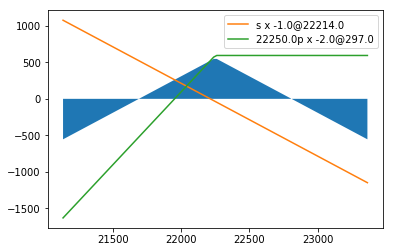

In [30]:
plot_payoff(['sx-1@22214', '22250px-2@297'])

In [31]:
get_greeks(['sx-1@22214', '22250px-2@297'])

,delta,gamma,vega,theta
right,,,,
f,-1.000000,0.000000,0.000000,0.000000
22250p,1.027737,-0.001144,-30.384562,25.823768
sum,0.027737,-0.001144,-30.384562,25.823768


### ロングストラドル

* ATMコールとATMプットを買う戦略
* 先物が動くまたはボラティリティが上昇することを狙った戦略

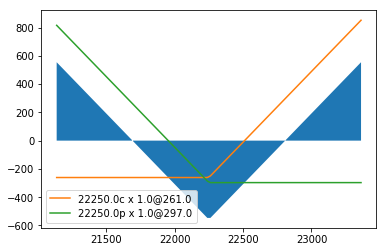

In [32]:
plot_payoff(['22250cx1@261', '22250px1@297'])

In [33]:
get_greeks(['22250cx1@261', '22250px1@297'])

,delta,gamma,vega,theta
right,,,,
22250c,0.486102,0.000572,15.192281,-12.972841
22250p,-0.513868,0.000572,15.192281,-12.911884
sum,-0.027766,0.001144,30.384562,-25.884725


### ショートストラドル

* ATMコールとATMプットを売る戦略
* 先物が動かないまたはボラティリティが低下することを狙った戦略

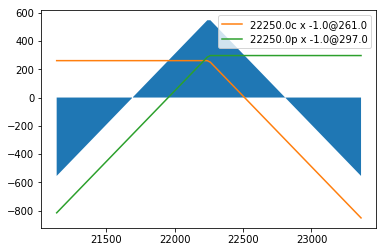

In [34]:
plot_payoff(['22250cx-1@261', '22250px-1@297'])

### ロングストラングル

* OTMコールとOTMプットを買う戦略
* 先物が大きく動くまたはボラティリティが大きく上昇することを狙った戦略

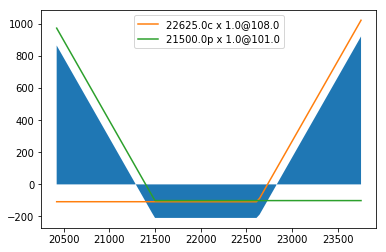

In [35]:
plot_payoff(['22625cx1@108', '21500px1@101'])

In [36]:
get_greeks(['22625cx1@108', '21500px1@101'])

,delta,gamma,vega,theta
right,,,,
22625c,0.272680,0.000506,12.661436,-10.167566
21500p,-0.200267,0.000317,10.676542,-11.534445
sum,0.072414,0.000823,23.337978,-21.702011


### ショートストラングル

* OTMコールとOTMプットを売る戦略
* 先物が動かないまたはボラティリティが低下することを狙った戦略
* 勝率が高いが非常にリスクが高い

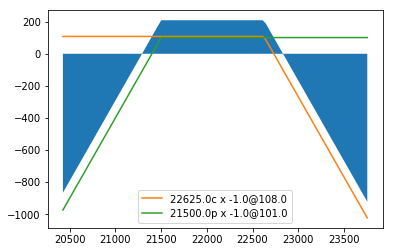

In [37]:
plot_payoff(['22625cx-1@108', '21500px-1@101'])

In [38]:
get_greeks(['22625cx-1@108', '21500px-1@101'])

,delta,gamma,vega,theta
right,,,,
22625c,-0.272680,-0.000506,-12.661436,10.167566
21500p,0.200267,-0.000317,-10.676542,11.534445
sum,-0.072414,-0.000823,-23.337978,21.702011


### デビットスプレッド

* OTMを買い、その外側のOTMを売る戦略
* ネイキッドロングの利益を限定した形だが、コストが安い

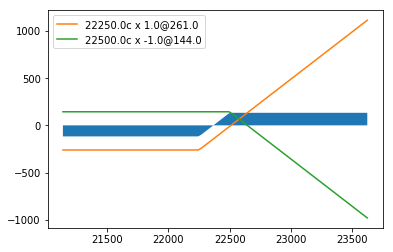

In [39]:
plot_payoff(['22250cx1@261', '22500cx-1@144'])

In [40]:
get_greeks(['22250cx1@261', '22500cx-1@144'])

,delta,gamma,vega,theta
right,,,,
22250c,0.486102,0.000572,15.192281,-12.972841
22500c,-0.338229,-0.000557,-13.934029,11.188627
sum,0.147874,0.000014,1.258252,-1.784214


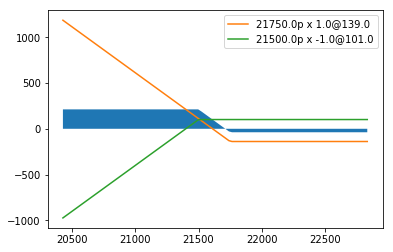

In [41]:
plot_payoff(['21750px1@139', '21500px-1@101'])

In [42]:
get_greeks(['21750px1@139', '21500px-1@101'])

,delta,gamma,vega,theta
right,,,,
21750p,-0.274758,0.000412,12.709052,-12.551943
21500p,0.200267,-0.000317,-10.676542,11.534445
sum,-0.074491,0.000096,2.032510,-1.017498


### クレジットスプレッド

* OTMを売り、その外側のOTMを買う戦略
* ネイキッドショートの損失を限定した形

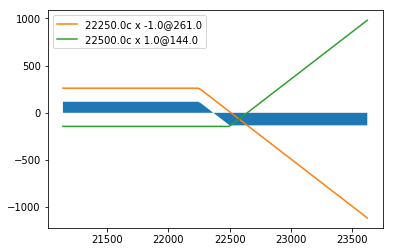

In [43]:
plot_payoff(['22250cx-1@261', '22500cx1@144'])

In [44]:
get_greeks(['22250cx-1@261', '22500cx1@144'])

,delta,gamma,vega,theta
right,,,,
22250c,-0.486102,-0.000572,-15.192281,12.972841
22500c,0.338229,0.000557,13.934029,-11.188627
sum,-0.147874,-0.000014,-1.258252,1.784214


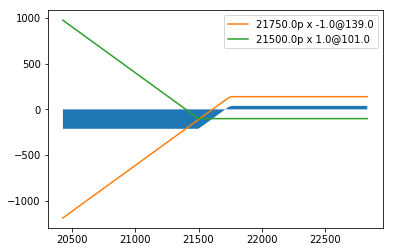

In [45]:
plot_payoff(['21750px-1@139', '21500px1@101'])

In [46]:
get_greeks(['21750px-1@139', '21500px1@101'])

,delta,gamma,vega,theta
right,,,,
21750p,0.274758,-0.000412,-12.709052,12.551943
21500p,-0.200267,0.000317,10.676542,-11.534445
sum,0.074491,-0.000096,-2.032510,1.017498


### ブルシンセティック(リスクリバーサルの売り)

* OTMコールを買い、OTMプットを売る戦略
* 先物ロングに似ているが、動きがなかった場合に中立となる
* ボラティリティの歪み(skew)をとる場合に組成される

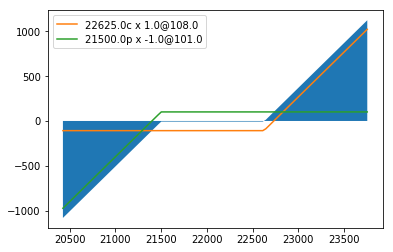

In [47]:
plot_payoff(['22625cx1@108', '21500px-1@101'])

In [48]:
get_greeks(['22625cx1@108', '21500px-1@101'])

,delta,gamma,vega,theta
right,,,,
22625c,0.272680,0.000506,12.661436,-10.167566
21500p,0.200267,-0.000317,-10.676542,11.534445
sum,0.472947,0.000190,1.984894,1.366879


### ベアシンセティック(リスクリバーサルの買い)

* OTMコールを売り、OTMプットを買う戦略
* 先物ショートに似ているが、動きがなかった場合に中立となる
* ボラティリティの歪み(skew)をとる場合に組成される

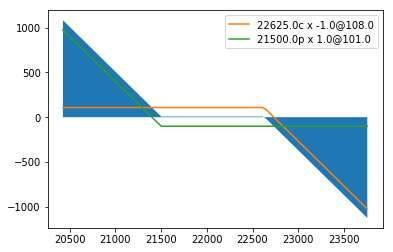

In [49]:
plot_payoff(['22625cx-1@108', '21500px1@101'])

In [50]:
get_greeks(['22625cx-1@108', '21500px1@101'])

,delta,gamma,vega,theta
right,,,,
22625c,-0.272680,-0.000506,-12.661436,10.167566
21500p,-0.200267,0.000317,10.676542,-11.534445
sum,-0.472947,-0.000190,-1.984894,-1.366879


### デルタヘッジ+ブルシンセティック(リスクリバーサルの売り)

* 先物でデルタを調整したシンセティック

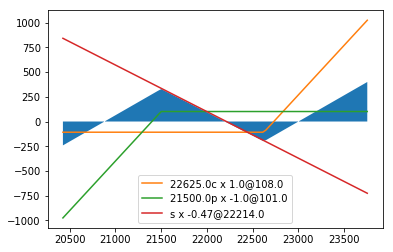

In [51]:
plot_payoff(['22625cx1@108', '21500px-1@101', 'sx-0.47@22214'])

In [52]:
get_greeks(['22625cx1@108', '21500px-1@101', 'sx-0.47@22214'])

,delta,gamma,vega,theta
right,,,,
22625c,0.272680,0.000506,12.661436,-10.167566
21500p,0.200267,-0.000317,-10.676542,11.534445
f,-0.470000,0.000000,0.000000,0.000000
sum,0.002947,0.000190,1.984894,1.366879


### デルタヘッジ+ベアシンセティック(リスクリバーサルの買い)

* 先物でデルタを調整したシンセティック

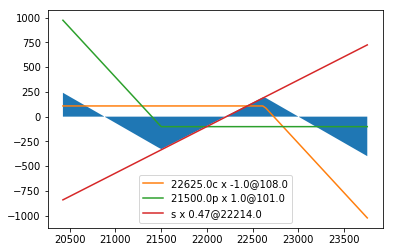

In [53]:
plot_payoff(['22625cx-1@108', '21500px1@101', 'sx0.47@22214'])

### レシオスプレッド

* オプションを買いその外側を複数売る戦略
* 先物が緩やかに動くことを狙って組成
* 勝率は高いがリスクも高い

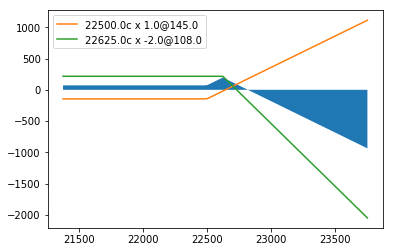

In [54]:
plot_payoff(['22500cx1@145', '22625cx-2@108'])

In [55]:
get_greeks(['22500cx1@145', '22625cx-2@108'])

,delta,gamma,vega,theta
right,,,,
22500c,0.338229,0.000557,13.934029,-11.188627
22625c,-0.545361,-0.001013,-25.322872,20.335132
sum,-0.207132,-0.000455,-11.388843,9.146505


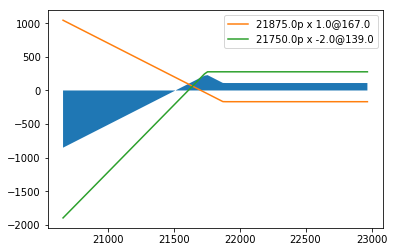

In [56]:
plot_payoff(['21875px1@167', '21750px-2@139'])

In [57]:
get_greeks(['21875px1@167', '21750px-2@139'])

,delta,gamma,vega,theta
right,,,,
21875p,-0.323431,0.000462,13.687263,-12.974453
21750p,0.549515,-0.000824,-25.418104,25.103885
sum,0.226084,-0.000362,-11.730841,12.129432


### バックスプレッド

* オプションを売りその外側を複数買う戦略
* ガンマとベガの上昇を効率よくとりにいける

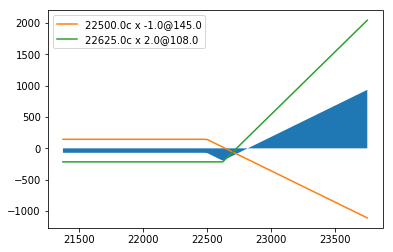

In [58]:
plot_payoff(['22500cx-1@145', '22625cx2@108'])

In [59]:
get_greeks(['22500cx-1@145', '22625cx2@108'])

,delta,gamma,vega,theta
right,,,,
22500c,-0.338229,-0.000557,-13.934029,11.188627
22625c,0.545361,0.001013,25.322872,-20.335132
sum,0.207132,0.000455,11.388843,-9.146505


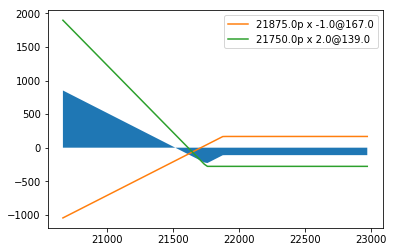

In [60]:
plot_payoff(['21875px-1@167', '21750px2@139'])

In [61]:
get_greeks(['21875px-1@167', '21750px2@139'])

,delta,gamma,vega,theta
right,,,,
21875p,0.323431,-0.000462,-13.687263,12.974453
21750p,-0.549515,0.000824,25.418104,-25.103885
sum,-0.226084,0.000362,11.730841,-12.129432


### ロングバタフライ

* オプションを1枚買いその外側を2枚売り、更にその外側を1枚買う戦略
* 精算値がオプションを売った位置にくると最大の利益となる
* コストが安い
* グリークスがほぼニュートラルで非常にリスクが少ない

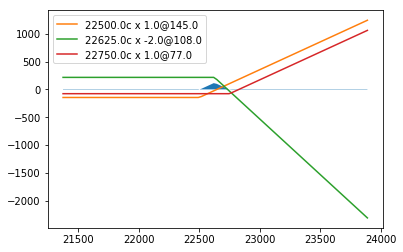

In [62]:
plot_payoff(['22500cx1@145', '22625cx-2@108', '22750cx1@77'])

In [63]:
get_greeks(['22500cx1@145', '22625cx-2@108', '22750cx1@77'])

,delta,gamma,vega,theta
right,,,,
22500c,0.338229,0.000557,13.934029,-11.188627
22625c,-0.545361,-0.001013,-25.322872,20.335132
22750c,0.211200,0.000447,11.018721,-8.729772
sum,0.004068,-0.000009,-0.370122,0.416733


### ショートバタフライ

* オプションを1枚売りその外側を2枚買い、更にその外側を1枚売る戦略
* 精算値がオプションを買った外側に来ると利益となる
* コストが安い
* グリークスがほぼニュートラルで非常にリスクが少ない

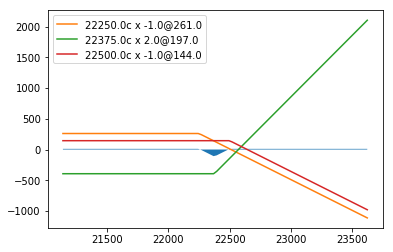

In [64]:
plot_payoff(['22250cx-1@261', '22375cx2@197', '22500cx-1@144'])

In [65]:
get_greeks(['22250cx-1@261', '22375cx2@197', '22500cx-1@144'])

,delta,gamma,vega,theta
right,,,,
22250c,-0.486102,-0.000572,-15.192281,12.972841
22375c,0.824490,0.001155,29.664632,-24.476199
22500c,-0.338229,-0.000557,-13.934029,11.188627
sum,0.000159,0.000026,0.538322,-0.314730


### ロングコンドル